In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from skactiveml.pool import GreedySamplingX
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import tqdm as tqdm
from sklearn.metrics import pairwise_distances


#read in data
df = pd.read_csv('vegetation_data.csv')

#create x and y variables
y = df["N"]
y = y.to_numpy()
X = df.drop(["N_level", "N","POINTID"], axis=1)

#fixing problem where EVI data has "inf" values
X = np.where(np.isinf(X), np.nan, X)
X = np.where(np.isnan(X), np.nanmean(X), X)



In [54]:
# creating some helper functions

#splitting data into train, pool, and test
def split_data(X,y,n_init, seed=seed):
    """splits the data into train,pool and test split with a pre-defined train size n_init."""

    n = len(y)


    X_train, X_pool, y_train, y_pool = train_test_split(X, y, train_size=n_init / n, random_state=seed)
    X_pool, X_test, y_pool, y_test = train_test_split(X_pool, y_pool, test_size=0.3, random_state=seed)
    return dict(
        train = dict(
            X=X_train,
            y=y_train
        ),
        pool = dict(
            X=X_pool,
            y=y_pool
        ),
        test = dict(
            X=X_test,
            y=y_test
        )
    )

# function to update the train and pool data
def update_data(data, idx):
    
    """Update of the data dictionary from `prepare_data` by moving the data
    point with index `idx` from the pool to the training set."""
    data['train']['X'] = np.append(data['train']['X'], np.atleast_2d(data['pool']['X'][idx]), axis=0)
    data['train']['y'] = np.append(data['train']['y'], np.atleast_1d(data['pool']['y'][idx]), axis=0)    
    data['pool']['X'] = np.delete(data['pool']['X'], idx, axis=0)
    data['pool']['y'] = np.delete(data['pool']['y'], idx, axis=0)



def calculate_uncertainty(model, X_pool):
   
    # Get the predictions from each tree in the forest
    predictions = np.array([tree.predict(X_pool) for tree in model.estimators_])
    # Calculate the variance of the predictions
    uncertainties = np.std(predictions, axis=0)
    
    return uncertainties 



#fix the fit model function
def fit_model( seed, strategy,query_strategy, n_init, n_iterations):
    """Run `n_iterations` of active learning or random sampling.
    RETURNS
    ----------
    scores : ndarray
        The score at each iteration.    
    """
    # Initialize
    data = split_data(X, y, n_init, seed)
    scores = np.zeros(n_iterations)
    model = RandomForestRegressor(random_state=seed, n_estimators=1000, max_depth=3, max_features=2,min_samples_leaf=20)

    # Do active learning for `n_iterations` by executing the steps listed above
    
    # solution::start
    for i in range(n_iterations):
        # 1. Fit the model
        model = model.fit(data['train']['X'], data['train']['y'])

        # 2. Evaluate model on pool
        #prob = model.predict_proba(data['pool']['X'])
        test_pred = model.predict(data['test']['X'])
        scores[i] = metrics.mean_absolute_error(test_pred, data['test']['y'])
        #scores[i] = model.score(data['test']['X'], data['test']['y'])

        # 3. Evaluate uncertainty on pool and query

        if i < n_iterations:
            if strategy == 'al':
                if query_strategy == 'greedy':
                    min_distances_input = np.min(pairwise_distances(data['pool']['X'], data['train']['X']), axis=1)
                    predicted_outputs = model.predict(data['pool']['X'])
                    min_distances_output = np.min(pairwise_distances(predicted_outputs.reshape(-1, 1), data['train']['y'].reshape(-1, 1)), axis=1)
                    combined_distances = min_distances_input * min_distances_output
                    idx = np.argmax(combined_distances)
                    #print("Selected index:", idx)
                elif query_strategy == 'variance':  
                    uncertainties = calculate_uncertainty(model, data['pool']['X'])
                    idx = np.argmax(uncertainties)

            elif strategy == 'random':
                idx = np.random.choice(len(data['pool']['X']), size=1,replace=False)[0]
                
            update_data(data, idx)

    return scores

In [55]:
# Settings
n_init = 100
n_iterations = 200 - n_init
n_avg = 10

# Average `n_avg` fits
scores_variance = np.zeros((n_avg, n_iterations))
scores_greedy = np.zeros((n_avg, n_iterations))
scores_rn = np.zeros((n_avg, n_iterations))






# run the active learning on the models
for i in tqdm.tqdm(range(n_avg)):
    seed = 3+i
    scores_variance[i] = fit_model(seed, "al","variance", n_init, n_iterations)
    scores_greedy[i] = fit_model(seed, "al","greedy", n_init, n_iterations)
    scores_rn[i] = fit_model(seed, "random",None, n_init, n_iterations)
    print(f'Iteration {i+1}/{n_avg} done')



 10%|█         | 1/10 [03:53<35:03, 233.68s/it]

Iteration 1/10 done


 20%|██        | 2/10 [08:06<32:40, 245.12s/it]

Iteration 2/10 done


 30%|███       | 3/10 [12:50<30:38, 262.57s/it]

Iteration 3/10 done


 40%|████      | 4/10 [17:19<26:31, 265.32s/it]

Iteration 4/10 done


 50%|█████     | 5/10 [21:27<21:34, 258.86s/it]

Iteration 5/10 done


 60%|██████    | 6/10 [25:43<17:12, 258.05s/it]

Iteration 6/10 done


 70%|███████   | 7/10 [30:18<13:10, 263.50s/it]

Iteration 7/10 done


 80%|████████  | 8/10 [34:35<08:42, 261.38s/it]

Iteration 8/10 done


 90%|█████████ | 9/10 [38:24<04:11, 251.39s/it]

Iteration 9/10 done


100%|██████████| 10/10 [43:02<00:00, 258.27s/it]

Iteration 10/10 done


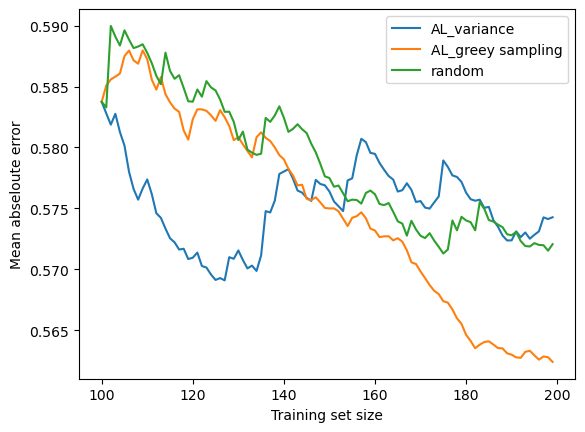

In [56]:
# Plot the results
fig, ax = plt.subplots(1, 1)
line1 = ax.plot(np.arange(n_init, n_iterations+n_init), scores_variance.mean(0),label='AL_variance')
line2 = ax.plot(np.arange(n_init, n_iterations+n_init), scores_greedy.mean(0),label='AL_greey sampling')
line3 = ax.plot(np.arange(n_init, n_iterations+n_init), scores_rn.mean(0),label='random')
ax.legend(handles=[line1[0], line2[0], line3[0]])
ax.set_xlabel('Training set size')
ax.set_ylabel('Mean abseloute error')
plt.show()